# Build your own portfolio that makes money in any economy with OpenBB

Risk parity is a strategy that uses risk to find the allocations of an investment portfolio. It allocates money to stocks based on a target risk level—usually volatility.

In other words, instead of equal dollar weights, risk parity has equal risk weights.

The problem with dollar-weighting is not every stock has the same risk. That means if you equally weigh two stocks, but one has higher risk, returns will be dominated by the higher-risk stock. Investors use risk parity to avoid this problem.

Risk parity is a strategy that works well in volatile markets.

In [28]:
from openbb_terminal.sdk import openbb
import riskfolio as rp
# Then grab the data.

new_highs = openbb.stocks.screener.screener_data("new_high")
port_data = new_highs[
    (new_highs.Price > 15) & (new_highs.Country == "USA")
]


tickers = port_data.Ticker.tolist()
tickers = ['VTI', 'VXUS', 'DBC', 'IAU', 'BND', 'BNDX']
data = openbb.economy.index(
    tickers,
    start_date="2016-01-01",
    end_date="2022-12-31"
)
data

,VTI,VXUS,DBC,IAU,BND,BNDX
Date,,,,,,
2016-01-04,90.110085,35.625801,12.806270,20.760000,66.480324,44.535881
2016-01-05,90.311829,35.561512,12.680718,20.799999,66.562683,44.510651
2016-01-06,89.101456,34.958767,12.477903,21.139999,66.859200,44.678745
2016-01-07,86.917564,34.235474,12.419956,21.440001,66.867401,44.611519
2016-01-08,85.926468,33.833656,12.362009,21.320000,66.949791,44.603115
...,...,...,...,...,...,...
2022-12-23,189.928162,51.066715,24.520000,34.110001,71.655510,47.390396
2022-12-27,189.134384,51.343071,24.740000,34.380001,71.102249,47.211639
2022-12-28,186.753098,50.731140,24.459999,34.220001,71.003456,47.191776


In [29]:
# OpenBB has a function that returns a list of stocks based on a screener. In this case, you’ll find stocks that are at new highs. Then filter this data to include only stocks with prices above $15 and from the US. Store the tickers in a list and download their historical data for a range of dates.

# Next, compute the returns and clean the data.

returns = data.pct_change()[1:]
returns.dropna(how="any", axis=1, inplace=True)
# Calculate the percentage change in the historical data to get the returns and drop any missing values.
returns

,VTI,VXUS,DBC,IAU,BND,BNDX
Date,,,,,,
2016-01-05,0.002239,-0.001805,-0.009804,0.001927,0.001239,-0.000567
2016-01-06,-0.013402,-0.016949,-0.015994,0.016346,0.004455,0.003777
2016-01-07,-0.024510,-0.020690,-0.004644,0.014191,0.000123,-0.001505
2016-01-08,-0.011403,-0.011737,-0.004666,-0.005597,0.001232,-0.000188
2016-01-11,-0.000612,0.002138,-0.027344,-0.008443,-0.004183,-0.001131
...,...,...,...,...,...,...
2022-12-23,0.005516,0.002325,0.018272,0.003530,-0.003134,-0.002196
2022-12-27,-0.004179,0.005412,0.008972,0.007916,-0.007721,-0.003772
2022-12-28,-0.012590,-0.011918,-0.011318,-0.004654,-0.001389,-0.000421


In [36]:
# Build the risk parity portfolio

# Now, let’s move on to building the risk parity portfolio using RiskFolio.

port = rp.Portfolio(returns=returns)

port.assets_stats(method_mu='hist', method_cov='hist', d=0.94)
rm = 'SMV'
rm = 'MV'

# port.lowerret = 0.0008
w_rp_c = port.rp_optimization(
    model="Classic",
    rm=rm,
    hist=True,
    rf=0,
    b=None
)

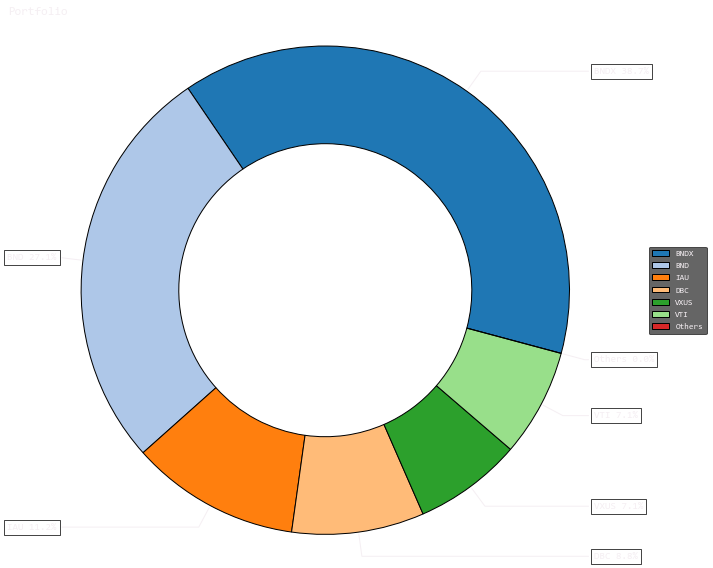

In [37]:
ax = rp.plot_pie(w=w_rp_c,
                 title='Portfolio',
                 height=8,
                 width=10,
                 cmap="tab20",
                 ax=None)

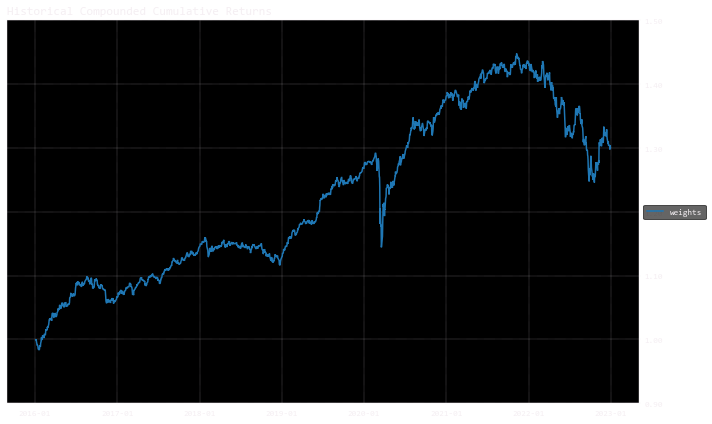

In [34]:
ax = rp.plot_series(returns=returns,
                    w=w_rp_c,
                    cmap='tab20',
                    height=6,
                    width=10,
                    ax=None)

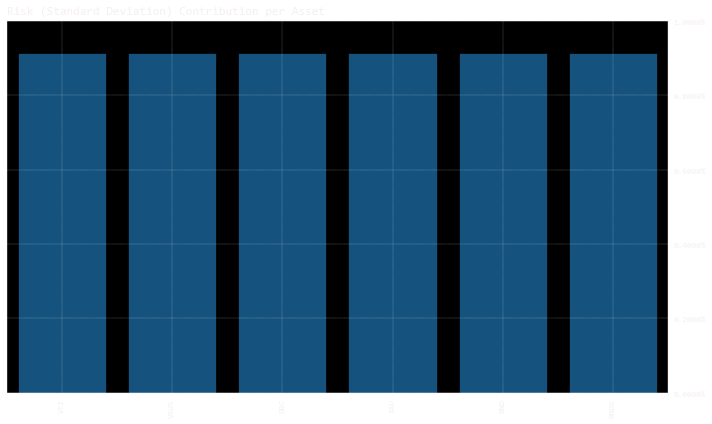

In [35]:
ax = rp.plot_risk_con(
    w_rp_c,
    cov=port.cov,
    returns=port.returns,
    rm="MV",
    rf=0,
)

In [17]:
# Risk parity figured out how the optimal risk weights to hit the minimum portfolio return constraint. The risk contribution of each stock varies depending on its volatility.

# Finally, compute the number of shares you need to invest in the portfolio.

port_val = 10_000
w_rp_c["invest_amt"] = w_rp_c * port_val
w_rp_c["last_price"] =  data.iloc[-1]
w_rp_c["shares"] = (w_rp_c.invest_amt / w_rp_c.last_price).astype(int)
w_rp_c

,weights,invest_amt,last_price,shares
BZH,0.013222,132.216090,12.760000,10
CIR,0.013137,131.371341,23.959999,5
BCC,0.017024,170.236453,65.732567,2
CCS,0.014144,141.440724,49.640461,2
NCLH,0.011235,112.352919,12.240000,9
RCL,0.012726,127.263496,49.430000,2
SAIA,0.021422,214.220702,209.679993,1
Z,0.016764,167.642183,32.209999,5
WDAY,0.021632,216.318739,167.330002,1
SUM,0.013375,133.754587,28.389999,4
